In [100]:
import os
import re
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
from matplotlib.pyplot import rc_context
from tqdm.notebook import tqdm, trange
from sklearn.preprocessing import MinMaxScaler
sc.settings.verbosity = 3

from tqdm import tqdm

In [101]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [102]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [103]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
experiment = "Tonsil"
adata = sc.read_h5ad(data_dir / "adata" /f"{experiment}_GC_1017.h5ad")

In [105]:
adata.var_names

Index(['CD20', 'CD21', 'CD27', 'CD3', 'CD38', 'CD4', 'CXCR5', 'EZH2',
       'H3K27me3', 'ICOS1', 'Ki67', 'PD1'],
      dtype='object')

In [106]:
adata.obs = adata.obs.reset_index(drop=True)


In [107]:
adata

AnnData object with n_obs × n_vars = 31156 × 12
    obs: 'Cell', 'Dataset', 'Core', 'leiden', 'Region_GC', 'Type'
    uns: 'Core_colors', 'Dataset_colors', 'Region_GC_colors', 'Type_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scanorama', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

# PseudoTime

In [108]:
adata_b = adata.copy()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


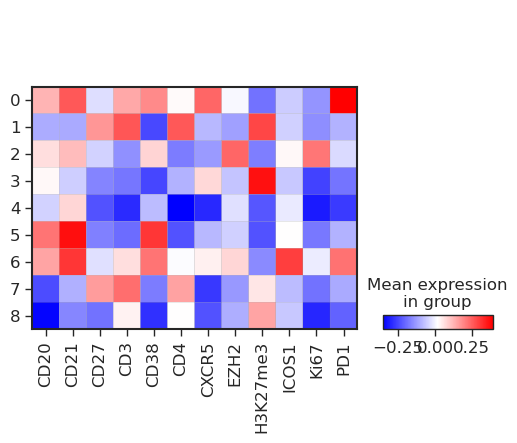

In [109]:
sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.matrixplot(adata, adata.var_names, groupby='leiden', cmap='bwr', dendrogram=False)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9945667  0.99095047 0.9871861  0.9838317  0.97996044
     0.9744176  0.9718769  0.9657546  0.9635944  0.9602088  0.9575661
     0.9554845  0.95347106 0.95149165]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


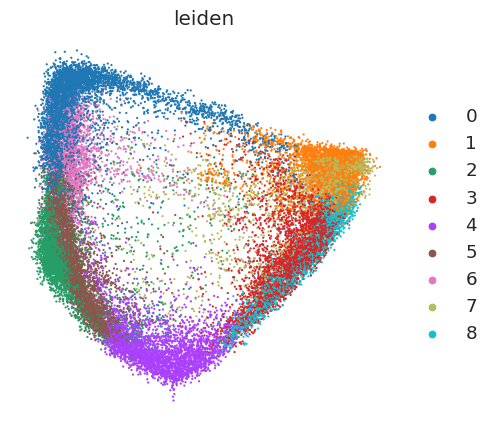

In [110]:
# Diff Map
adata_ = adata_b.copy()

sc.tl.diffmap(adata_)
adata_.obsm["X_diffmap_"] = np.arcsinh(
    adata_.obsm["X_diffmap"][:, [1,2]]
)

fig, ax = plt.subplots(figsize=(5,5))
sc.pl.embedding(adata_, 'diffmap_', color=['leiden'], size=10, ax=ax, frameon=False)

In [111]:
adata_ = adata_[~adata_.obs.leiden.isin(['1', '3', '7', '8'])]
sc.tl.leiden(adata_, resolution=0.8)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


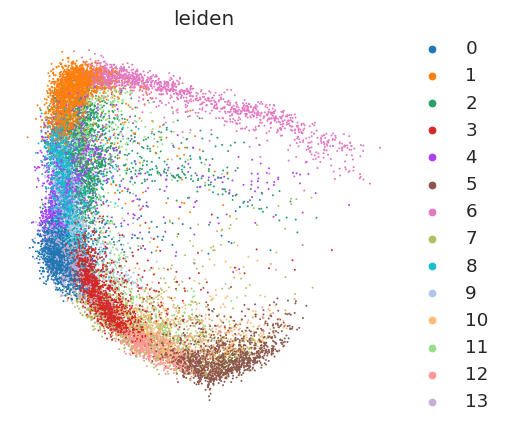

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


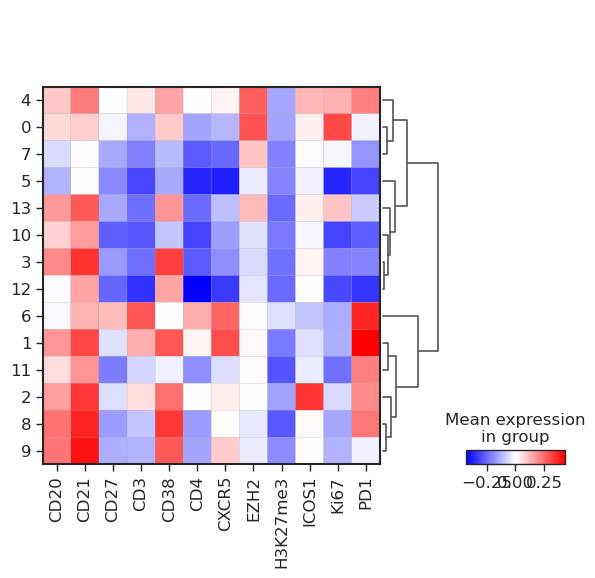

In [112]:
fig, ax = plt.subplots(figsize=(5,5))
sc.pl.embedding(adata_, 'diffmap_', color=['leiden'], size=8, ax=ax, frameon=False)

sc.tl.dendrogram(adata_, groupby='leiden')
sc.pl.matrixplot(adata_, adata_.var_names, groupby='leiden', cmap='bwr', dendrogram=True)

In [13]:
adata_ = adata_[~adata_.obs.leiden.isin(['5','6'])]


In [14]:
b_markers = ['CD20', 'Ki67', 'CXCR5', 'CD27', 'CD38', 'CD21', 'PD1', 'EZH2']
sc.pp.neighbors(adata_, metric='cosine')
sc.tl.diffmap(adata_, n_comps=5)

adata_.obsm["X_diffmap_"] = adata_.obsm["X_diffmap"][:, [1,2]]


computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)
computing Diffusion Maps using n_comps=5(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.        0.9911382 0.9879794 0.9784108 0.9744095]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


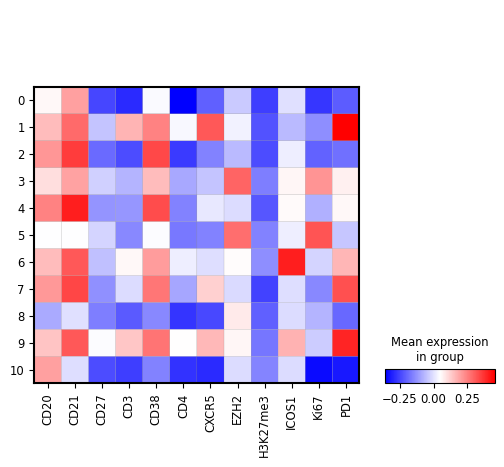

In [15]:
sc.pp.neighbors(adata_, use_rep='X_diffmap')
sc.tl.leiden(adata_, resolution=0.18)

sc.tl.dendrogram(adata_, groupby='leiden')
sc.pl.matrixplot(adata_, adata_.var_names, groupby='leiden', cmap='bwr', dendrogram=False)

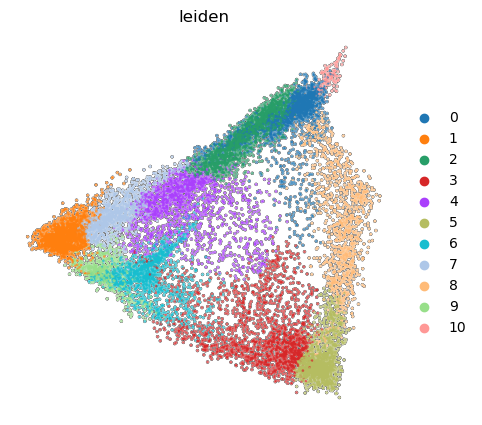

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
sc.pl.embedding(adata_, 'diffmap_', color=['leiden'], ax=ax, frameon=False, add_outline=True, 
                outline_width=(0.1, 0.05), outline_color=('black', 'white'), size=14)

In [17]:
import matplotlib 

colors = adata_.uns["leiden_colors"]
labels = adata_.obs.leiden.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

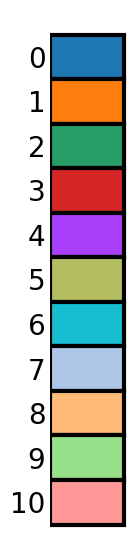

In [18]:
# legend
fig, ax = plt.subplots(figsize=(1,7))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=20)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


## Spatial Projection

In [19]:
import networkx as nx
import numpy as np
import pandas as pd
import skimage 
from skimage import measure

# Plotting
def create_intensity_cell(mask, cell2intensity, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.float)*np.nan

    for cell, intensity in tqdm(cell2intensity.items(), total=len(cell2intensity)):
        rows, cols = np.where(np.isin(mask, cell))
        img[rows, cols] = intensity
    return img

def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks

def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i, cells in tqdm(label2cell.items(), total=len(label2cell)):
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]

    return img

def get_contour(mask: np.ndarray):
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

In [20]:
masks = get_masks(data_dir / "masks", f"tonsil")

In [21]:

# for dataset in adata_.obs['Core'].unique():
#     adata_fov = adata_[adata_.obs['Core'] == dataset]

#     try:
#         mask = masks["_".join(['tonsil', dataset])]
#         contours = get_contour(mask)
#     except:
#         print(dataset)
#         continue
#      # Get label2cell dict
    
#     label2cell = {}
#     for i, l in enumerate(labels):
#         cell_id = adata_fov[adata_fov.obs.leiden == l].obs.Cell.to_list()
#         label2cell[i] = cell_id

#     img = create_clustered_cell(mask, label2cell, colors_rgb)

#     fig, ax = plt.subplots(figsize=(7, 7))
#     ax.imshow(img)
#     for j, contour in enumerate(contours):
#         ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
#     ax.axis("off")
#     plt.show()
#     fig.savefig(f'2_{dataset}.png', bbox_inches='tight',transparent=True, pad_inches=0)


## Pseudotime

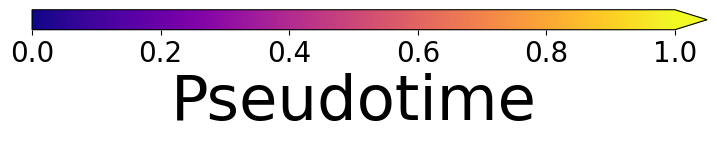

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.size':20})

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(15, 2))
ax1 = fig.add_axes([0.0, 0.15, 0.45, 0.1])

norm = mpl.colors.Normalize(vmin=0, vmax=1)

# Fist Cell type
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap='plasma',
                                norm=norm, extend='max',
                                orientation='horizontal')
cb1.set_label(f'Pseudotime', fontsize=45)



computing Diffusion Pseudotime using n_dcs=5
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


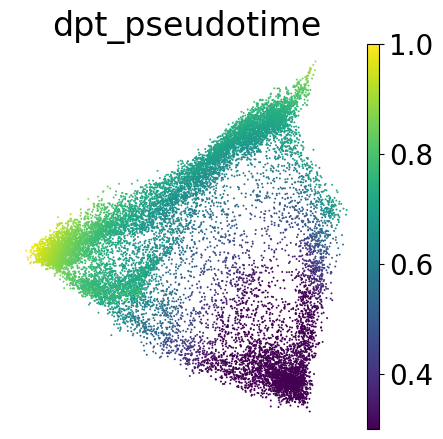

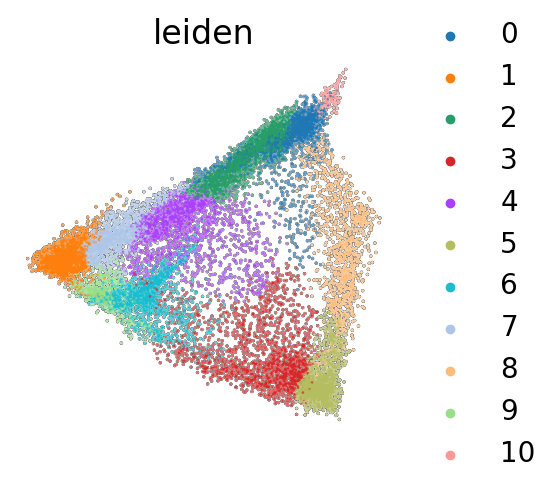

In [23]:
# Pseudo time 
adata_.uns['iroot'] = np.flatnonzero(adata_.obs['leiden']  == '5')[0]
sc.tl.dpt(adata_, n_dcs=5)

fig, ax = plt.subplots(figsize=(5,5))
sc.pl.embedding(adata_, 'diffmap_', color=['dpt_pseudotime'], size=8, ax=ax, frameon=False, cmap='viridis', vmin=0.3)

fig, ax = plt.subplots(figsize=(5,5))
sc.pl.embedding(adata_, 'diffmap_', color=['leiden'], ax=ax, frameon=False, add_outline=True, outline_width=(0.1, 0.05), outline_color=('black', 'white'), size=14)

In [97]:
tsne = pd.read_csv('palentir_tsne.csv')
tsne = tsne.iloc[:, 1:]

In [98]:
tsne

x          y
0     -18.520336  -4.599929
1      -5.853693  50.313244
2      -6.724799  47.703083
3     -22.195066  -3.650255
4      -7.216205  51.019512
...          ...        ...
14387  65.218180   1.046621
14388   5.382371 -13.185715
14389  -6.025725 -41.414790
14390  -1.643586  43.656780
14391 -10.816497  51.032295

[14392 rows x 2 columns]

In [99]:
adata_.obsm['X_tsne'] = tsne.values
sc.pl.tsne(adata_, color=['dpt_pseudotime'], cmap='viridis', add_outline=True, outline_width=(0.2, 0.05), 
           outline_color=('black', 'white'), size=10, frameon=False)

sc.pl.tsne(adata_, color='leiden', add_outline=True, outline_width=(0.2, 0.05), outline_color=('black', 'white'), size=30, frameon=False)

ValueError: Value passed for key 'X_tsne' is of incorrect shape. Values of obsm must match dimensions (0,) of parent. Value had shape (14392, 2) while it should have had (15655,).

In [26]:
# Rename clusters
mapping = dict(zip(
    ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], 
    ['AB1', 'LZ', 'AB2', 'DZ3', 'LZ1', 'DZ2', 'LZ1', 'LZ2', 'DZ1', 'LZ2', 'AB3']
))
# Define new clusters
adata_.obs["Phenotype"] = (
    adata_.obs["leiden"]
    .map(lambda x: mapping.get(x, x))
    .astype("category")
)
adata_.uns["Phenotype_colors"] = adata_.uns["leiden_colors"]  

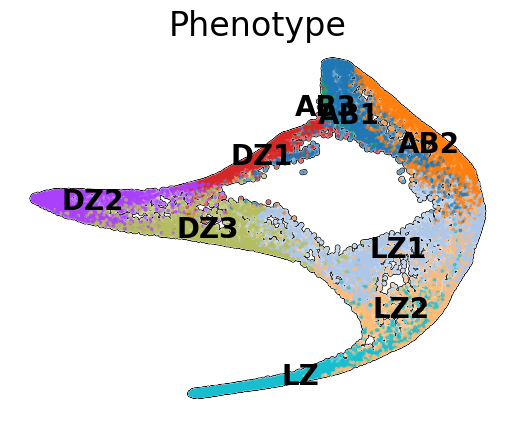

In [27]:
sc.pl.tsne(adata_, color='Phenotype', add_outline=True, outline_width=(0.2, 0.05), 
           outline_color=('black', 'white'), size=30, frameon=False,
           legend_loc='on data')

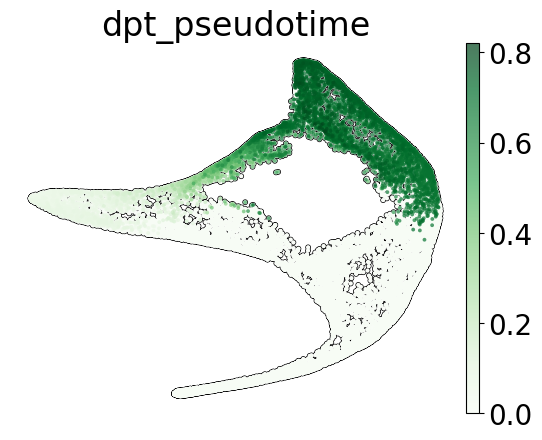

In [28]:
p = ['5', '3', '9', '7', '1']
p = ['5', '8', '0', '2']
# p = ['0', '2', '4', '7', '1']


adata_traj = adata_.copy()
dps_pseudo = adata_traj.obs['dpt_pseudotime']
dps_pseudo[~adata_traj.obs.leiden.isin(p)] = 0
adata_traj.obs['dpt_pseudotime'] = dps_pseudo.values

sc.pl.tsne(adata_traj, color=['dpt_pseudotime'], cmap='Greens', add_outline=True, outline_width=(0.2, 0.05), 
           outline_color=('black', 'white'), size=30, frameon=False, legend_loc=None, na_color='white')

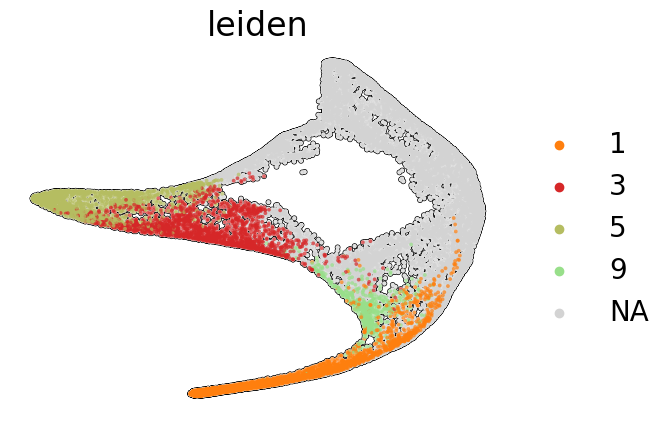

In [29]:
paths = [('DZ LZ', ['5', '3', '9', '1'])]
sc.pl.tsne(adata_, color='leiden', groups=paths[0][1], add_outline=True, outline_width=(0.2, 0.05), outline_color=('black', 'white'), size=30, frameon=False, na_color='lightgray')

In [30]:
adata_.obs['distance'] = adata_.obs['dpt_pseudotime']
adata_.obs['distance_r'] = adata_.obs['dpt_pseudotime']
adata_.obs['clusters'] = adata_.obs['leiden']  # just a cosmetic change
adata_.uns['clusters_colors'] = adata_.uns['leiden_colors']


In [31]:
gene_names_ = ['CD20', 'CXCR5', 'Ki67', 'CD27', 'CD38', 'PD1']

0 ('DZ LZ', ['5', '3', '9', '1'])


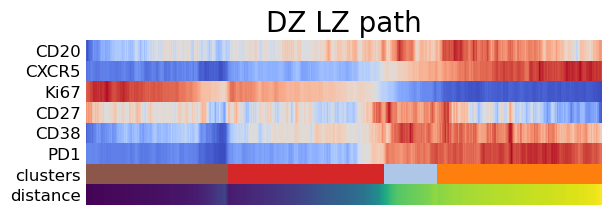

In [32]:
_, axs = plt.subplots(ncols=1, figsize=(6, round(len(gene_names_)/3)), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    print (ipath,(descr, path))
    _, data = sc.pl.paga_path(
        adata_, path, gene_names_,
        show_node_names=False,
#         ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='coolwarm',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis', 'distance_r': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        normalize_to_zero_one=True,
        show=False)
    
plt.show()

In [33]:
adata_btraj = adata_[adata_.obs['leiden'].isin(paths[0][1])]

## Palentir

In [34]:
import palantir
%matplotlib inline
import logging

logging.getLogger('matplotlib.font_manager').disabled = True

adata_temp = adata_.copy()
# adata_temp = adata_temp[:, ['CD20', 'CD21', 'CD27', 'CD38', 'CXCR5', 'EZH2', 'H3K27me3', 'ICOS1', 'Ki67', 'PD1']]
adata_temp.obs = adata_temp.obs.reset_index(drop=True)

pca_projections, _ = palantir.utils.run_pca(adata_temp, n_components=5, use_hvg=False, )
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=5)
ms_data = palantir.utils.determine_multiscale_space(dm_res)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


computing PCA
    with n_comps=5
    finished (0:00:00)
Determing nearest neighbor graph...
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [35]:
# tsne = palantir.utils.run_tsne(ms_data, perplexity=500)
# adata_temp.obsm['X_tsne'] = tsne.values

In [36]:
embeddings = tsne
adata_temp.obsm['X_tsne'] = tsne.values

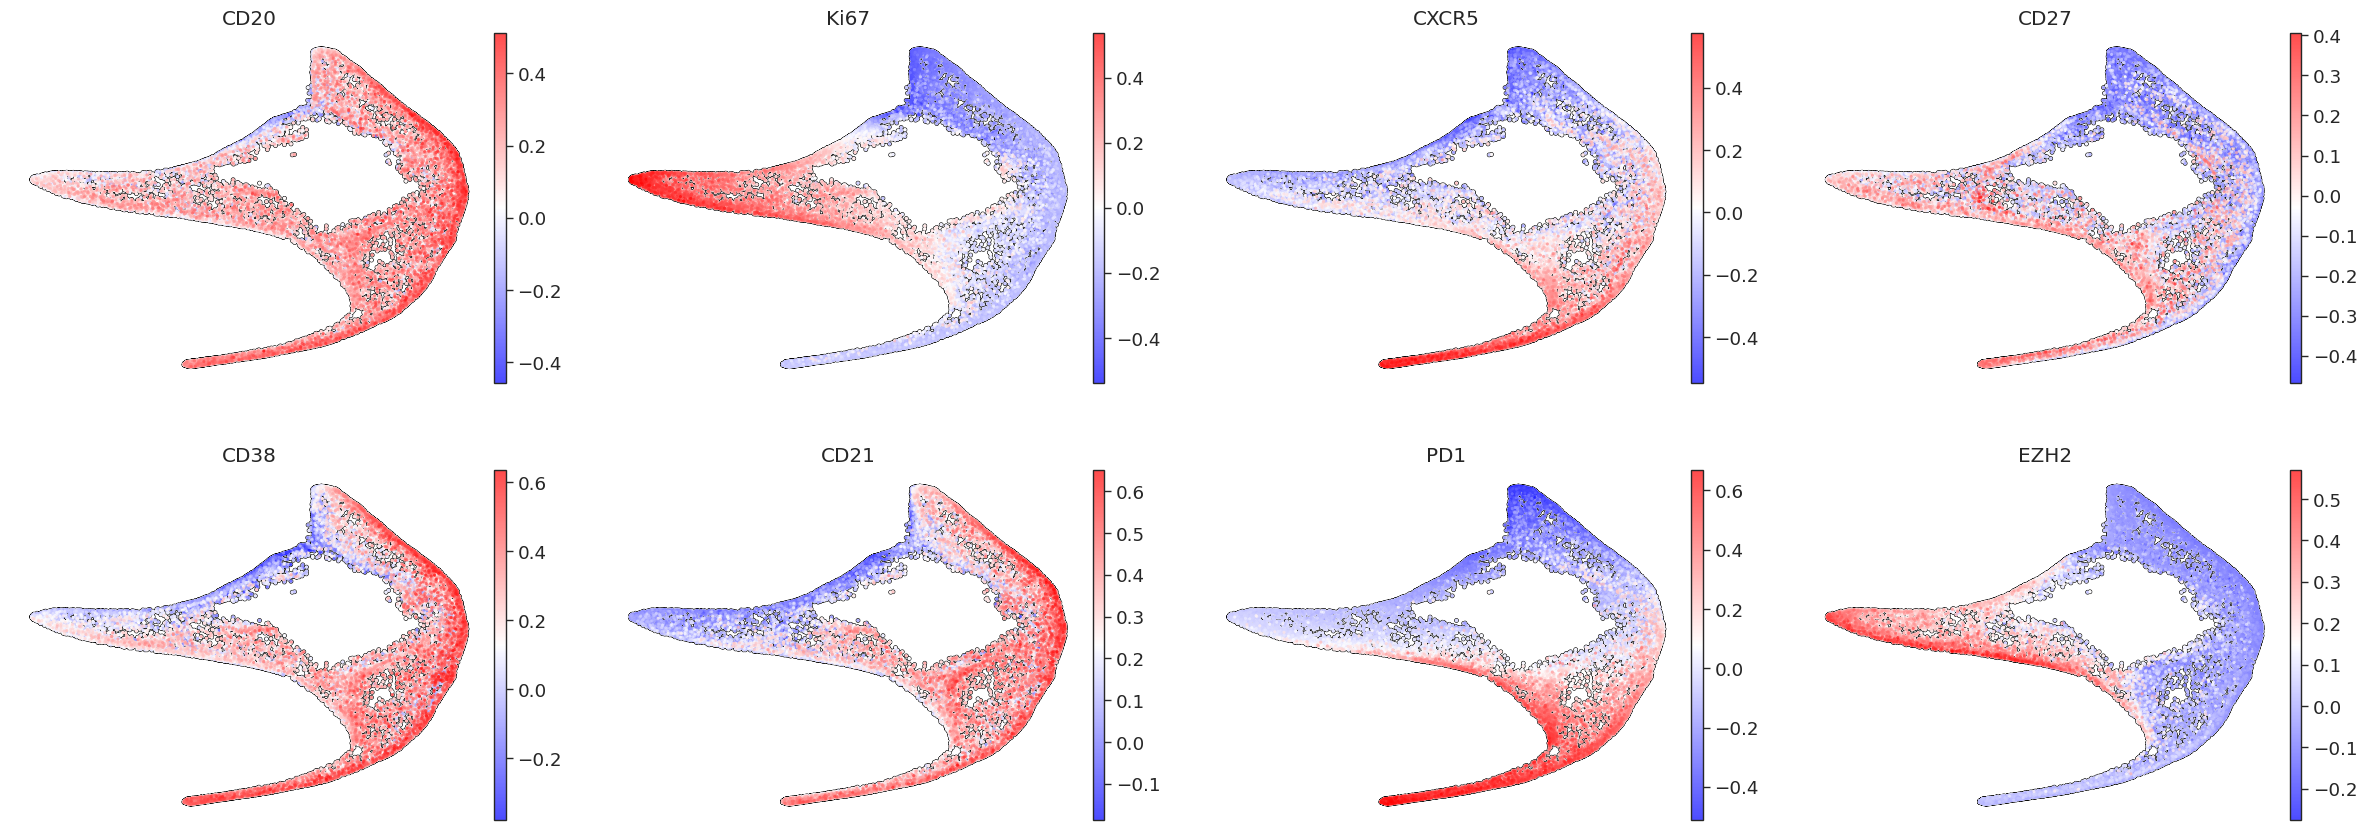

In [37]:
sc.pl.embedding(adata_temp, basis='tsne', color=['CD20', 'Ki67', 'CXCR5', 'CD27', 'CD38', 'CD21', 'PD1', 'EZH2'],  
                cmap='bwr', add_outline=True, outline_width=(0.2, 0.05), outline_color=('black', 'white'), size=20, frameon=False)

In [38]:
# tsne.to_csv('palentir_tsne1.csv')

(<Figure size 400x400 with 1 Axes>, <AxesSubplot: >)

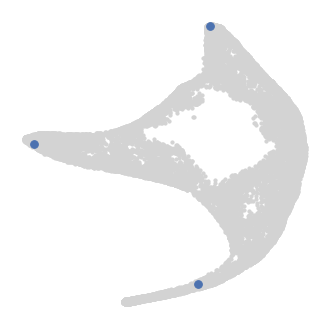

In [39]:
cells = [np.flatnonzero(adata_temp.obs['leiden']  == '5')[10], 
         np.flatnonzero(adata_temp.obs['leiden']  == '1')[10],
        np.flatnonzero(adata_temp.obs['leiden']  == '0')[-10]]
palantir.plot.highlight_cells_on_tsne(embeddings, cells)


In [40]:
terminal_states = pd.Series(['AB', 'LZ'], 
                           index=[np.flatnonzero(adata_temp.obs['leiden']  == '0')[-10],
                                 np.flatnonzero(adata_temp.obs['leiden']  == '1')[10]])

start_cell = np.flatnonzero(adata_temp.obs['leiden']  == '5')[10]
pr_res = palantir.core.run_palantir(ms_data, start_cell, num_waypoints=500, terminal_states=terminal_states.index)


Sampling and flocking waypoints...
Time for determining waypoints: 0.01928391456604004 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.1741059184074402 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9997
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [41]:
adata_temp.obs['Palentir_dps'] = pr_res.pseudotime[embeddings.index]

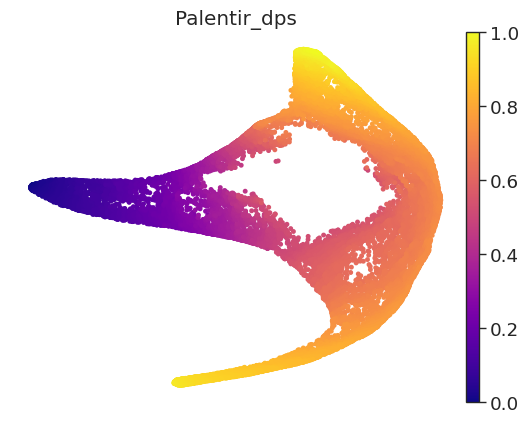

In [42]:
sc.pl.embedding(adata_temp, basis='tsne',
               color=['Palentir_dps'], frameon=False, cmap='plasma', size=50)

In [43]:
adata_temp

AnnData object with n_obs × n_vars = 15655 × 12
    obs: 'Cell', 'Dataset', 'Core', 'leiden', 'Region_GC', 'Type', 'dpt_pseudotime', 'Phenotype', 'distance', 'distance_r', 'clusters', 'Palentir_dps'
    uns: 'Core_colors', 'Dataset_colors', 'Region_GC_colors', 'Type_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'neighbors', 'umap', 'diffmap_evals', 'iroot', 'Phenotype_colors', 'clusters_colors', 'pca'
    obsm: 'X_scanorama', 'X_umap', 'spatial', 'X_diffmap', 'X_diffmap_', 'X_tsne', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

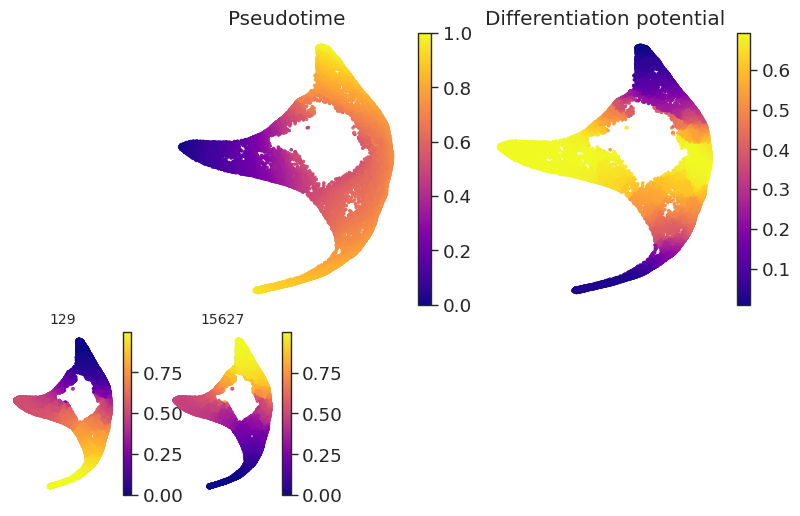

In [44]:
palantir.plot.plot_palantir_results(pr_res, embeddings)

In [45]:
adata_temp.var_names

Index(['CD20', 'CD21', 'CD27', 'CD3', 'CD38', 'CD4', 'CXCR5', 'EZH2',
       'H3K27me3', 'ICOS1', 'Ki67', 'PD1'],
      dtype='object')

Unable to determine R home: [WinError 2] The system cannot find the file specified


LZ
Time for processing LZ: 0.10544341007868449 minutes
AB
Time for processing AB: 0.020209133625030518 minutes


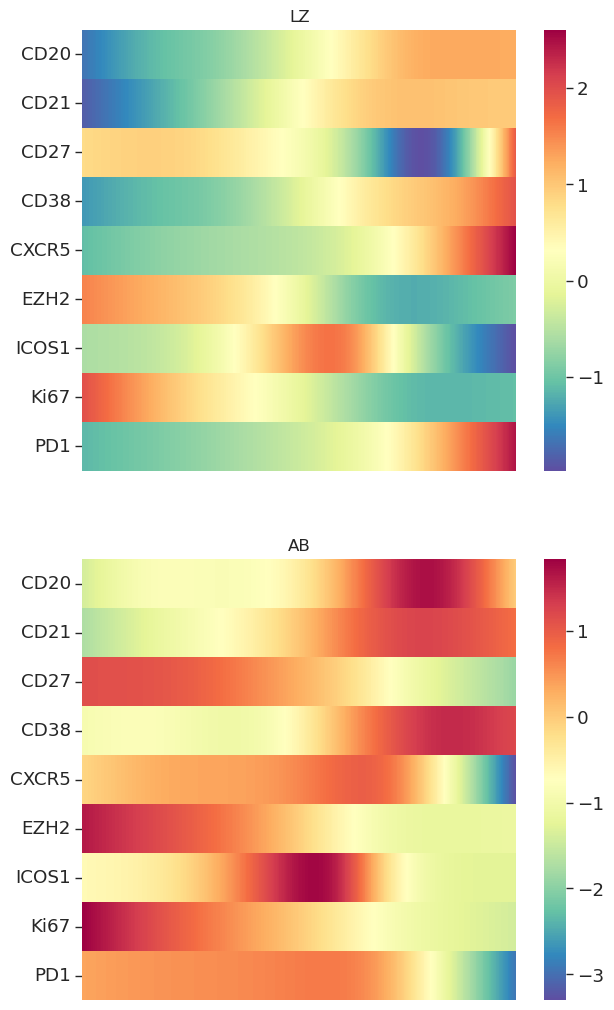

In [46]:
gene_names_ = ['CD20', 'CD21', 'CD27', 'CD38','CXCR5', 'EZH2','ICOS1', 'Ki67', 'PD1']

# Plot gene trends
try:
    pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]
except:
    pass
gene_trends = palantir.presults.compute_gene_trends(pr_res, pd.DataFrame(adata_temp[:, gene_names_].X, columns=gene_names_))
palantir.plot.plot_gene_trend_heatmaps(gene_trends)


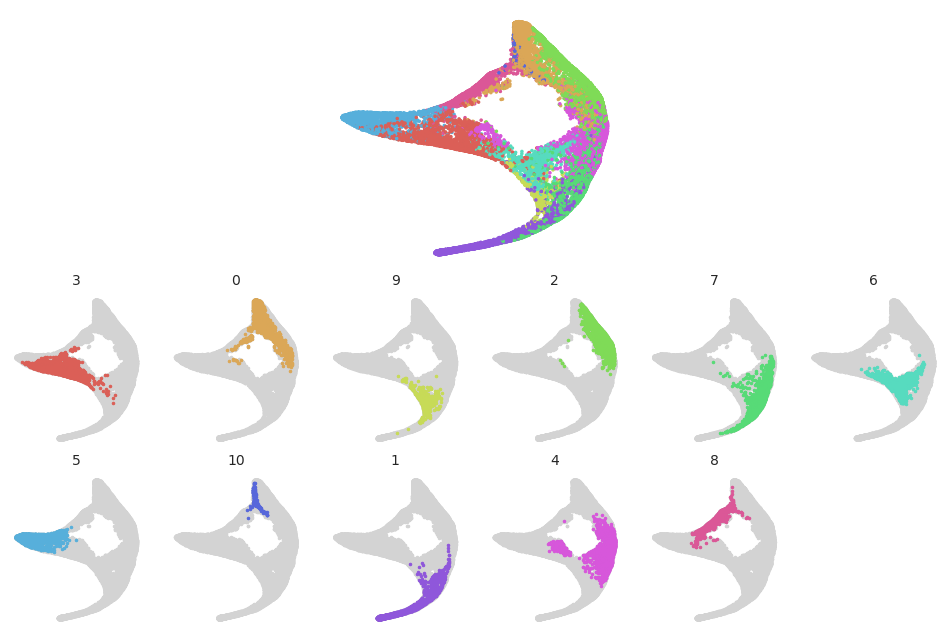

In [47]:
palantir.plot.plot_cell_clusters(embeddings, adata_temp.obs.leiden)


In [48]:
# sc.pl.embedding(adata_temp[::10], color=['leiden'], basis='tsne', frameon=False, size=400, add_outline=True, outline_width=(0.1, 0.01), outline_color=('black', 'white'), cmap='bwr')

# Check metabolites channels with high correlation with pseudo time

## Read metabolites data 

In [49]:
experiment = "tonsil"
cores = ["DonorA", "DonorE"]
datasets = [core + f"_{i}" for core in cores for i in range(1, 7)]

In [50]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [51]:
%%capture 

adatas = []
adatas_raw = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    # data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    
    # FPM normalize
    sc.pp.normalize_total(adata, target_sum=1e5)
    # sc.pp.log1p(adata, base=2)
    adatas_raw.append(adata.copy())
    
    # Standard scale
    sc.pp.scale(adata)
    adatas.append(adata)
    
adata = ad.concat(adatas, join="inner")
adata_raw = ad.concat(adatas_raw, join="inner")

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [52]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 20000)].index.tolist()

In [53]:
len(mz_qc)

140

In [54]:
adata = adata[:, mz_qc]

In [55]:
adata

View of AnnData object with n_obs × n_vars = 31156 × 140
    obs: 'Cell', 'Dataset', 'Core'
    obsm: 'spatial'

In [56]:
SIMS_masses = adata.var_names

In [57]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_09012022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()

# get matched table by looking at difference with error
error = 0.4
matched_dfs = []
for mz in SIMS_masses.astype(float):
    if mz < 1.1:
        continue
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
    else:
        matched = pd.DataFrame([['', '', '', '', mz]], columns=df.columns.tolist() + ['SIMS mz'])
        matched_dfs.append(matched)
matched = pd.concat(matched_dfs)

In [58]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)

SIMS_nm_subset = SIMS_masses_subset + 'm/z ' + SIMS_name_subset

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 139


In [59]:
adata_all = adata.copy()
adata = adata[:, SIMS_masses_subset]
adata.var_names = SIMS_nm_subset

## Correlate with pseudo time for B cell trajectory

In [60]:
from sklearn.preprocessing import LabelEncoder
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


### Palentir

In [61]:
%matplotlib inline

In [62]:
adata.obs = adata.obs.reset_index(drop=True)
adata.obs.index = adata.obs.index.astype(str)

In [63]:
adata_met_subset = adata[adata_.obs.index]
adata_met_subset.obs["Pseudotime"] = pr_res.pseudotime.tolist()

In [64]:
adata_met_subset.obs['Trajectory'] = pr_res.branch_probs.idxmax(axis=1).tolist()
adata_met_subset.obs['Pseudotime'] = pr_res.pseudotime.tolist()
adata_met_subset.obsm['X_tsne'] = adata_temp.obsm['X_tsne']

In [88]:
traj = 'LZ'
adata_s = adata_met_subset[pr_res.branch_probs[traj] > 0.7]
df = pd.DataFrame(adata_s.X, columns=adata_s.var_names.tolist())
df['Pseudotime'] = adata_s.obs['Pseudotime'].tolist()
df_corr = df.corr()

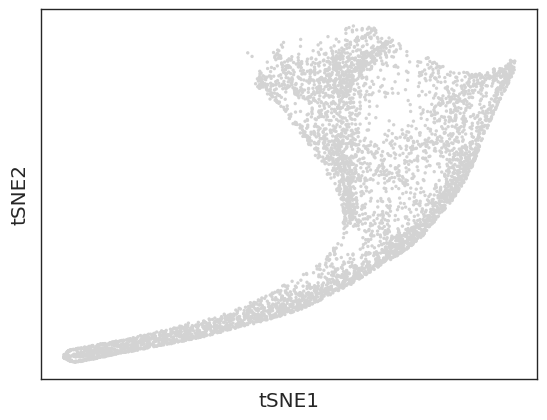

In [89]:
sc.pl.embedding(adata_s, basis='tsne')

In [90]:
n = 10
marker = 'Pseudotime'

n_cut = 50

# Get positive and negative correlation
corr_pos = df_corr.loc[marker].nlargest(25).index.tolist()
corr_neg = df_corr.loc[marker].nsmallest(25).index.tolist()

# Get only SIMS masses
corr_pos = [corr for corr in corr_pos if corr in SIMS_nm_subset][:n]
corr_neg = [corr for corr in corr_neg if corr in SIMS_nm_subset][:n]
corr_list = [marker] + corr_pos + corr_neg

# Get range 
df_intensity = df[corr_list]
df_intensity.sort_values(by=[marker], inplace=True)
df_intensity[f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop') 

LE = LabelEncoder()
df_intensity[f'{marker} cut'] = LE.fit_transform(df_intensity[f'{marker} cut'])

In [91]:
df_sort = df_intensity.groupby('Pseudotime cut').mean()
df_sort.drop('Pseudotime', inplace=True, axis=1)

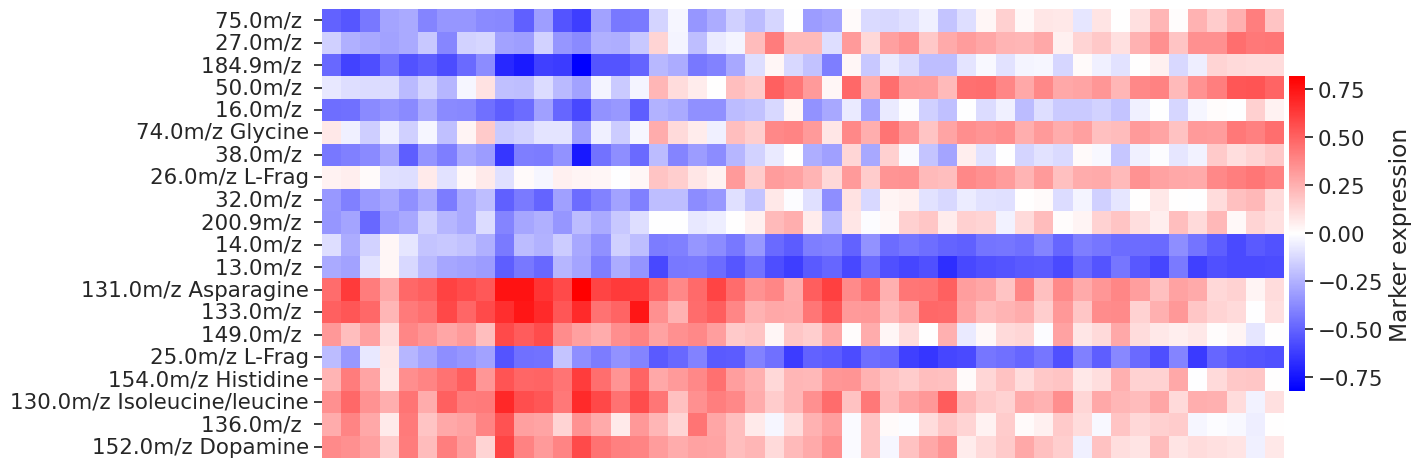

In [92]:
with sns.plotting_context('notebook', font_scale=1.4):
    fig, ax = plt.subplots(figsize=(15,5))
    ax = sns.heatmap(df_sort.T, ax=ax, cmap='bwr',
                     xticklabels=False, yticklabels=True, 
                     cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7})
    ax.set(xlabel='')
    plt.tight_layout()
    plt.show()

In [93]:
df_mean = df_intensity.groupby('Pseudotime cut').transform('mean')
adata_mean = ad.AnnData(df_mean.values)
adata_mean.var_names = ['pdt'] + df_mean.columns.tolist()[1:]
adata_mean.obs = adata_s.obs.copy()
adata_mean.obsm = adata_s.obsm.copy()

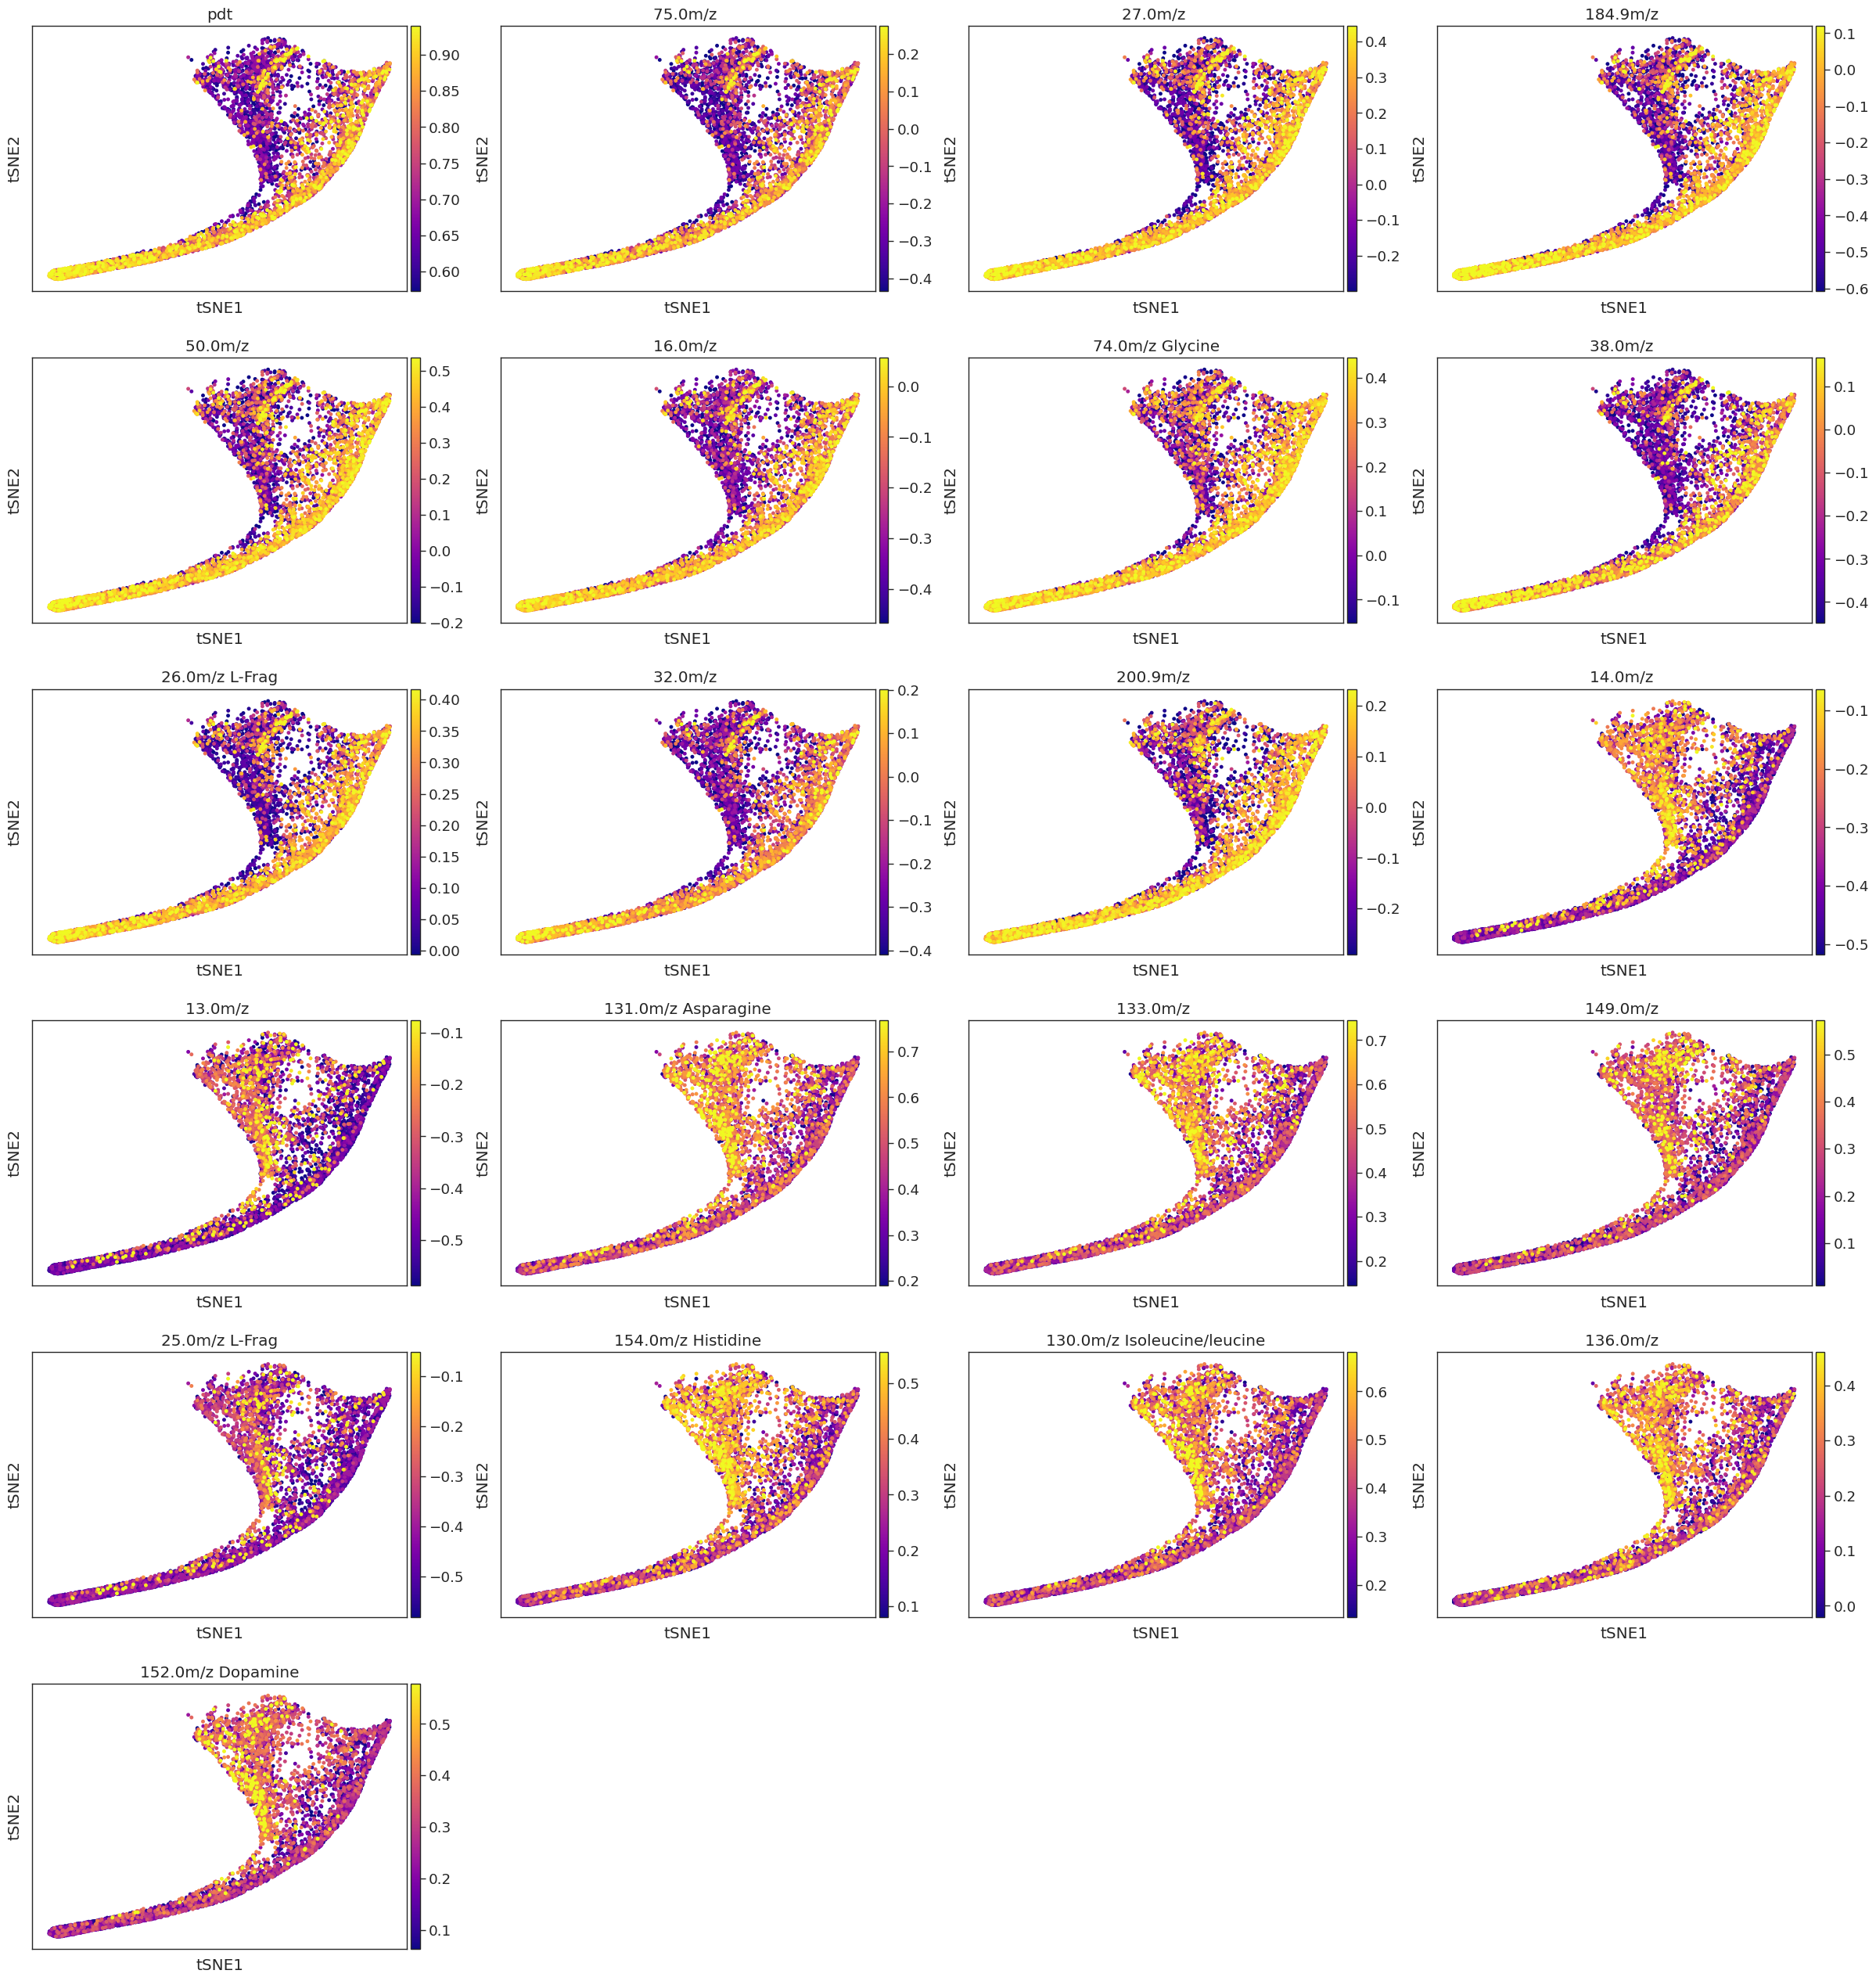

In [94]:
sc.pl.embedding(adata_mean, basis='tsne', color=adata_mean.var_names, cmap='plasma', size=50, vmin='p10', vmax='p98')

In [ ]:
sc.pl.embedding(adata_met_subset, basis='tsne', color=corr_list, cmap='bwr', size=20)

### PseudoTime

In [ ]:
adata.obs = adata.obs.reset_index(drop=True)
adata.obs.index = adata.obs.index.astype(str)

In [ ]:
adata_

In [ ]:
adata_met_subset = adata[adata_.obs.index]
adata_met_subset.obsm['X_tsne'] = adata_.obsm['X_tsne']
adata_met_subset.obs['Pseudotime'] = adata_btraj.obs['dpt_pseudotime']
adata_met_subset = adata_met_subset[~adata_met_subset.obs.Pseudotime.isna()]

In [ ]:
df = pd.DataFrame(adata_met_subset.X, columns=adata_met_subset.var_names.tolist())
df['Pseudotime'] = adata_btraj.obs['dpt_pseudotime'].tolist()
df_corr = df.corr()

In [ ]:
n = 10
marker = 'Pseudotime'

n_cut = 50

# Get positive and negative correlation
corr_pos = df_corr.loc[marker].nlargest(25).index.tolist()
corr_neg = df_corr.loc[marker].nsmallest(25).index.tolist()

# Get only SIMS masses
corr_pos = [corr for corr in corr_pos if corr in SIMS_nm_subset][:n]
corr_neg = [corr for corr in corr_neg if corr in SIMS_nm_subset][:n]
corr_list = [marker] + corr_pos + corr_neg

# Get range 
df_intensity = df[corr_list]
df_intensity.sort_values(by=[marker], inplace=True)
df_intensity[f'{marker} cut'] = pd.qcut(df_intensity[marker], n_cut, duplicates='drop') 

LE = LabelEncoder()
df_intensity[f'{marker} cut'] = LE.fit_transform(df_intensity[f'{marker} cut'])

In [ ]:
df_sort = df_intensity.groupby('Pseudotime cut').mean()

In [ ]:
with sns.plotting_context('notebook', font_scale=1.4):
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.heatmap(df_sort.T, ax=ax, cmap=heatmap_cmp,
                     xticklabels=False, yticklabels=True, 
                     cbar_kws={"label": "Marker expression", "pad": 0.004, "shrink": 0.7}, 
                     vmin=-0.5, vmax=0.5)
    ax.set(xlabel='')
    plt.tight_layout()
    plt.show()

In [ ]:
sc.pl.embedding(adata_met_subset, basis='tsne', color=corr_list, cmap='bwr', size=50)